# ISA with $\alpha=3$

I trained this model 16 times (N=20000) and what to check how large the fluctuations are from the models weight initialition. 
This is _one_ source of randomness in a NN.

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import InvariantSlotAttention

# Set numpy seed for test set sampling 
np.random.seed(24082023)

from matplotlib.patches import Circle
import json

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

In [6]:
cID_all = [f'isa-alpha3_{i}' for i in range(16)]
cID_prev = cID_all[0]
# nothing differs in these networks so just take first one to load configs:
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [7]:
torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

In [8]:
load_model_at = []
for cID_prev in cID_all:
    f = open(f'./../../code/models/{cID_prev}/loss.json')
    # returns JSON object as a dictionary
    losses = json.load(f)
    epoch_loss_min = np.argmin(losses["tot"])
    epoch_loss_min = round(epoch_loss_min, -3) # round to 1000 a model gets saved every 1000 epoch!
    load_model_at.append(epoch_loss_min)

In [9]:
load_model_at

[16000,
 7000,
 19000,
 5000,
 9000,
 17000,
 19000,
 7000,
 19000,
 9000,
 16000,
 8000,
 14000,
 11000,
 6000,
 11000]

## Evaluate model

In [12]:
k_slots=3
max_n_rings=2
resolution=(32,32)

In [13]:
from train import hungarian_matching
import torch.nn.functional as F
import evaluation as ev

In [10]:
plt.style.use('standard_style.mlpstyle')

Starting from an earlier training 16000


/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/Invariant-Slot-Attention (ISA) methods/./../../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


KL-divergence:  0.011050007


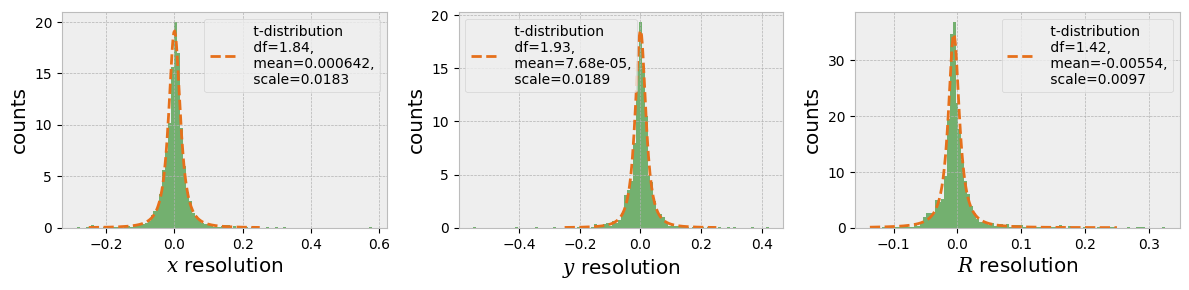

Starting from an earlier training 7000
KL-divergence:  0.011894615


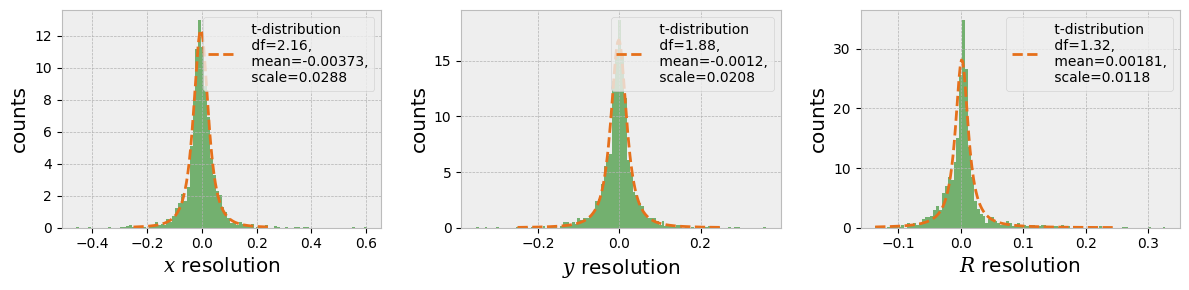

Starting from an earlier training 19000
KL-divergence:  0.01153902


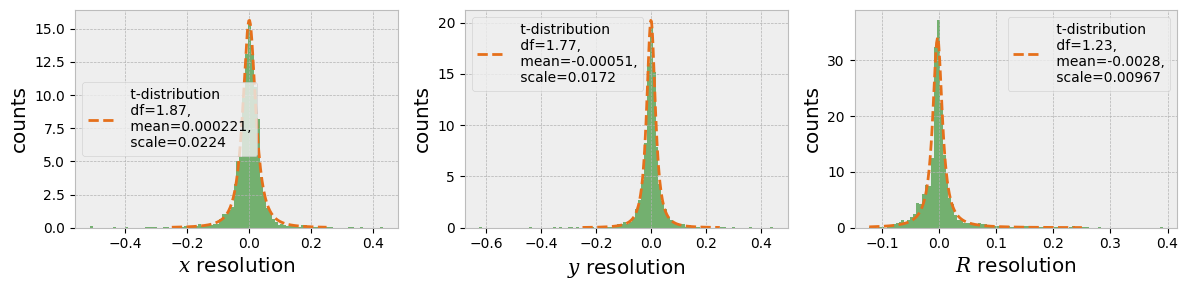

Starting from an earlier training 5000
KL-divergence:  0.010816882


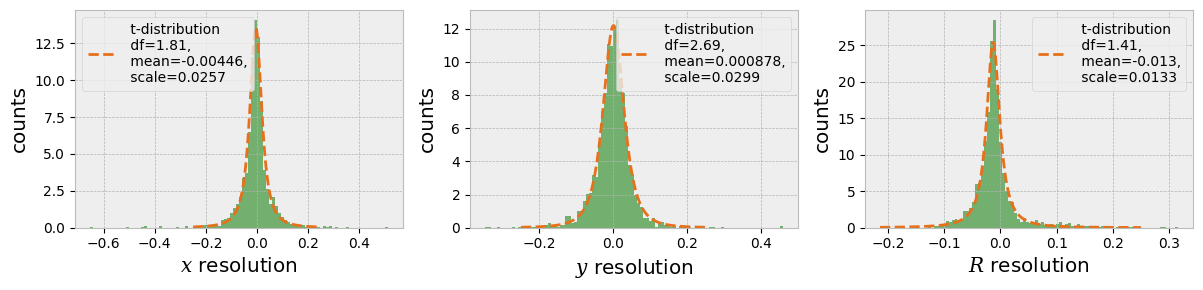

Starting from an earlier training 9000
KL-divergence:  0.010941801


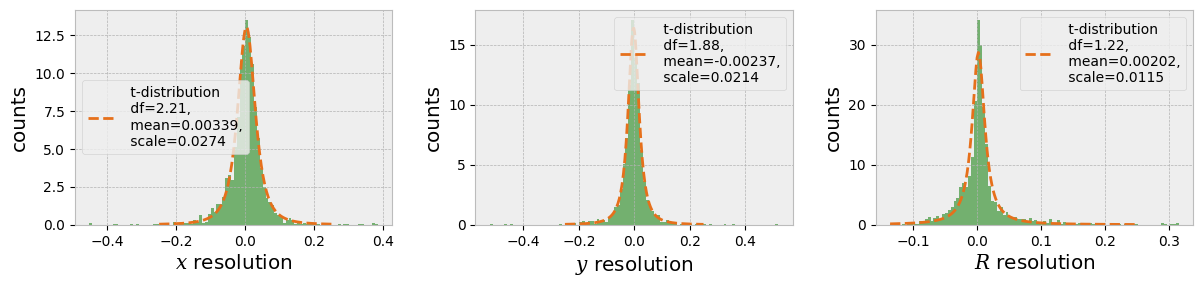

Starting from an earlier training 17000
KL-divergence:  0.010071575


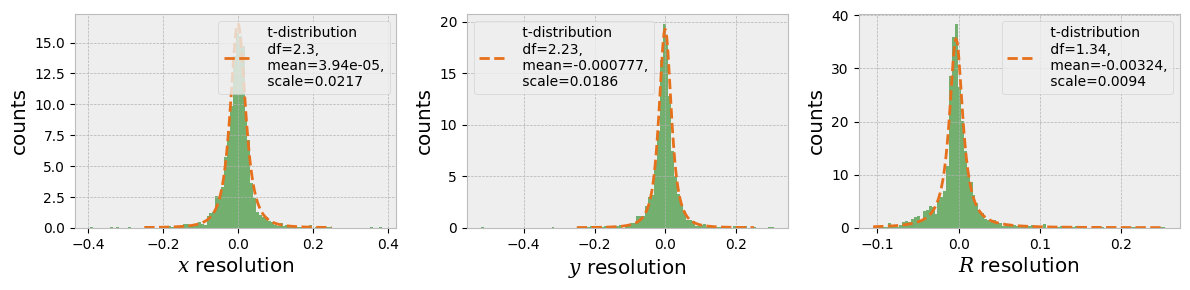

Starting from an earlier training 19000
KL-divergence:  0.00552481


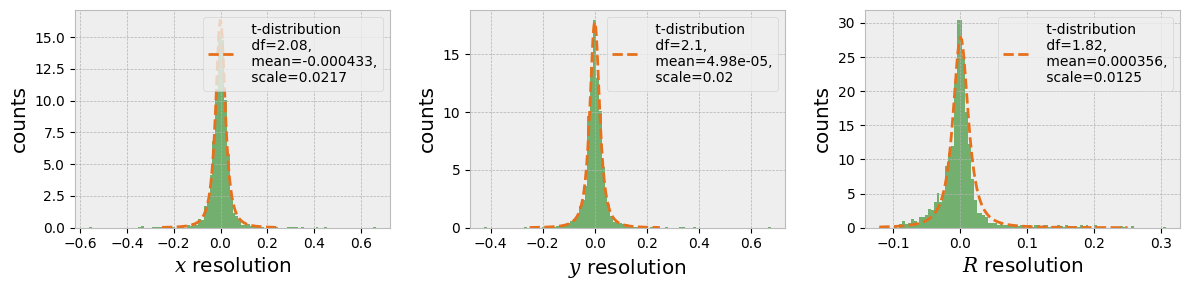

Starting from an earlier training 7000
KL-divergence:  0.012380624


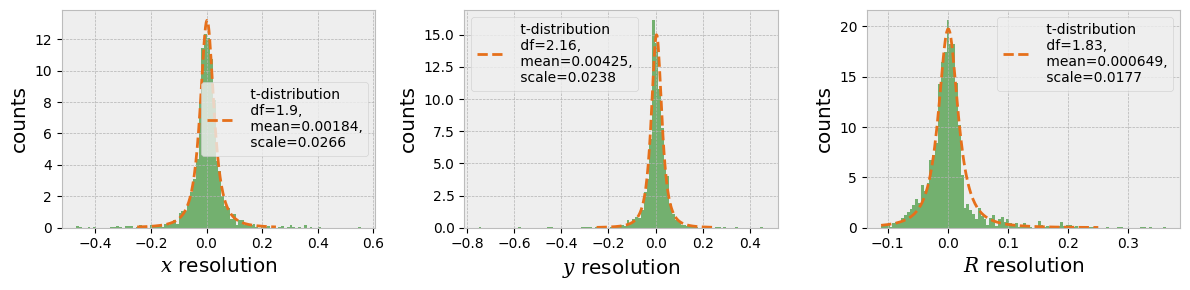

Starting from an earlier training 19000
KL-divergence:  0.008502545


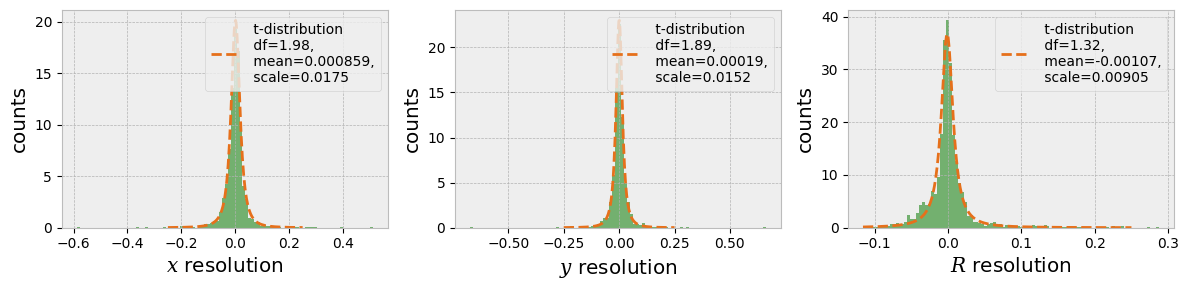

Starting from an earlier training 9000
KL-divergence:  0.007998519


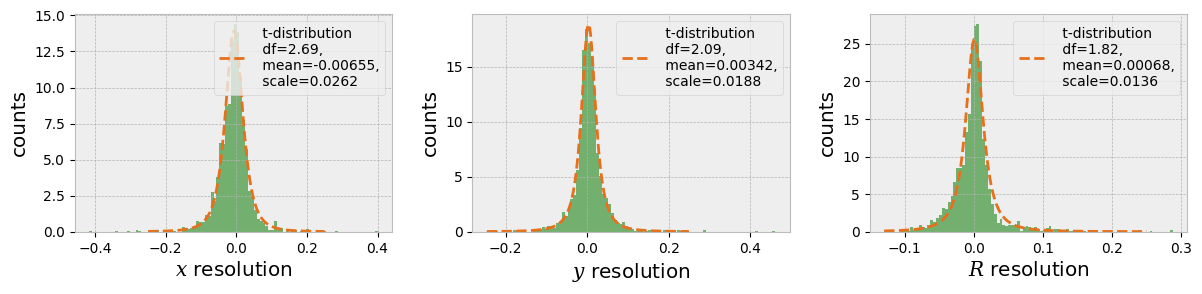

Starting from an earlier training 16000
KL-divergence:  0.010988625


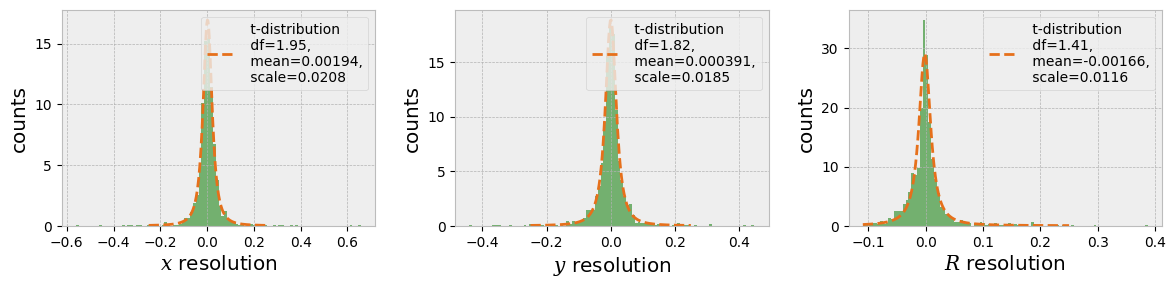

Starting from an earlier training 8000
KL-divergence:  0.008786478


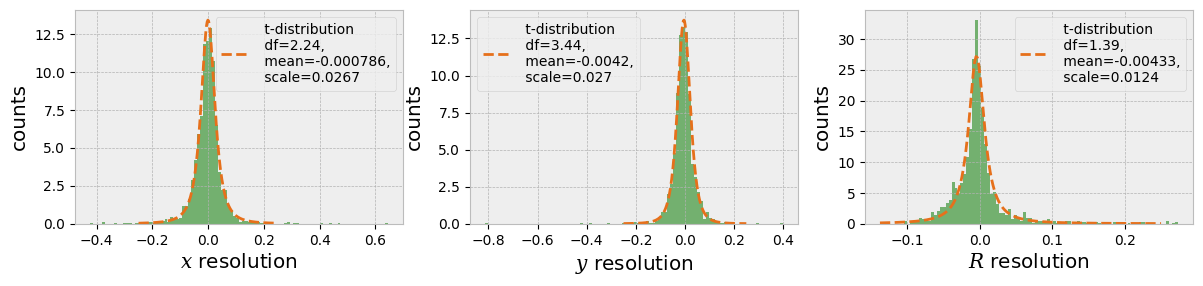

Starting from an earlier training 14000
KL-divergence:  0.0086224405


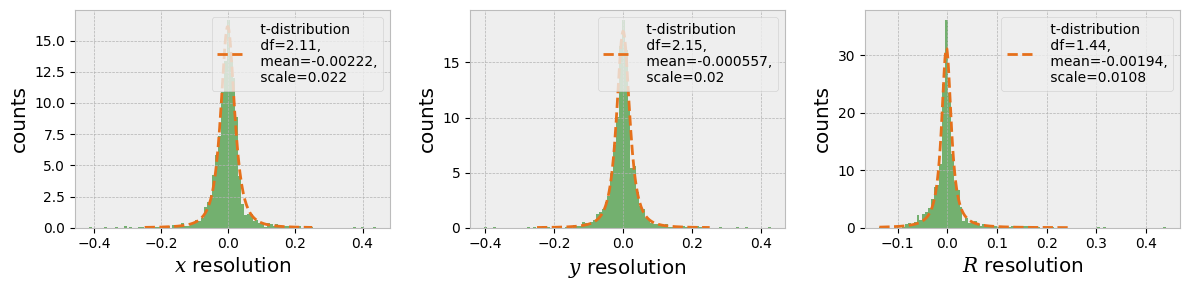

Starting from an earlier training 11000
KL-divergence:  0.010514672


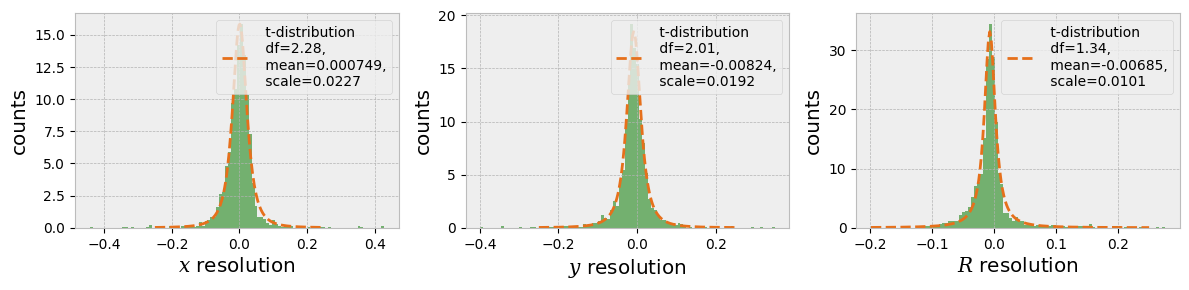

Starting from an earlier training 6000
KL-divergence:  0.005091833


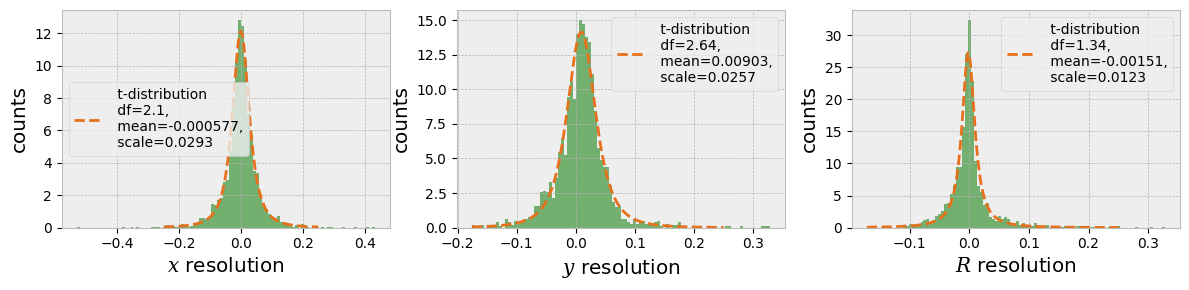

Starting from an earlier training 11000
KL-divergence:  0.009792642


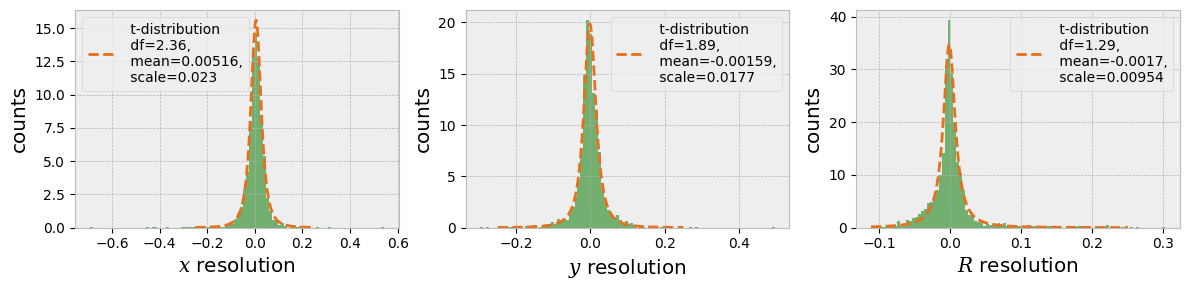

In [14]:
result = {}
for i, cID_prev in enumerate(cID_all):
    with open(f'./../../code/configs/{cID_prev}.yaml') as f:
        cd = yaml.safe_load(f)
    alpha = cd['opt']['alpha']
    
    m = InvariantSlotAttention(**hps)
    
    # load model
    lastIter = load_model_at[i]
    weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
    print(f'Starting from an earlier training',lastIter)

    m.load_state_dict(torch.load(weightPath,map_location=device))
    
    # make data
    bs = 1000
    kwargs = cd['data']
    X, Y, mask = make_batch(N_events=bs, **kwargs)
    
    # check network 
    with torch.no_grad():

        torch.manual_seed(torch_seed)
        queries, att, Y_pred = m(X)

        # Reshape the target mask to be flat in the pixels (same shape as att)
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      

        att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
        mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

        pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)

        # pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
        indices = hungarian_matching(pairwise_cost)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        # Loss calc
        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

        Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean(axis=-1)

        # Calculate the loss
        #print(l_bce.shape)
        #print(l_mse.shape)
        li = l_bce + alpha*l_mse
        
        
        
        ### performance of network!
        kl_div = ev.KL_divergence(slots_sorted, rings_sorted)
        print("KL-divergence: ", kl_div)
        fit_params = ev.student_t(Y_pred_sorted, Y_true_sorted)
        # save results 
        result[cID_prev] = {"kl-div": kl_div, "t-fit": fit_params}
    

Let's check the KL-divergence!

In [15]:
kl_div_res = [a["kl-div"] for a in result.values()]

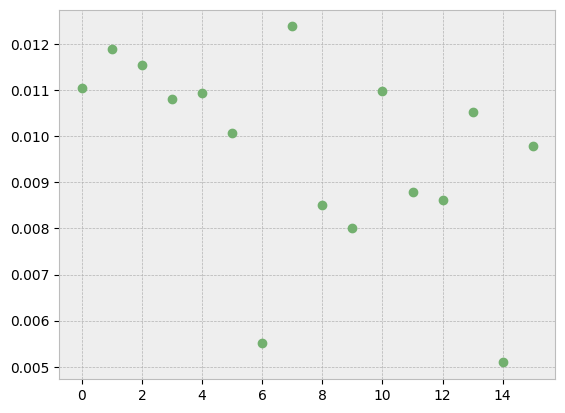

In [17]:
plt.plot(np.arange(len(kl_div_res)), kl_div_res, "o")

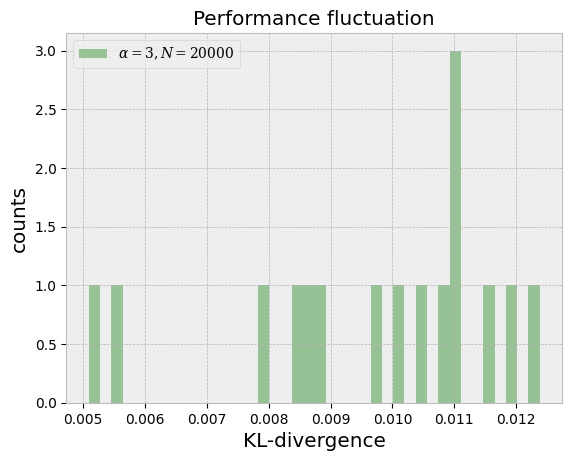

In [28]:
plt.hist(kl_div_res, bins=40, label=r"$\alpha=3, N=20 000$", alpha=0.7)
plt.xlabel("KL-divergence")
plt.ylabel("counts")
plt.legend()
plt.title("Performance fluctuation")
plt.show()